Nilesh Aapparao Kale [AI3105]

In [ ]:
!pip install tensorflow pandas matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving warsaw.csv to warsaw.csv


In [ ]:
df = pd.read_csv("/content/warsaw.csv")
df.head()


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNWD,TAVG,TMAX,TMIN
0,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-01,0.0,10.0,-8.3,NaN,NaN
1,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-02,NaN,10.0,-14.9,NaN,NaN
2,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-03,0.0,10.0,-13.6,-9.7,NaN
3,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-04,0.0,10.0,-10.5,-6.5,-13.3
4,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-05,0.0,10.0,-12.0,-8.9,-14.1


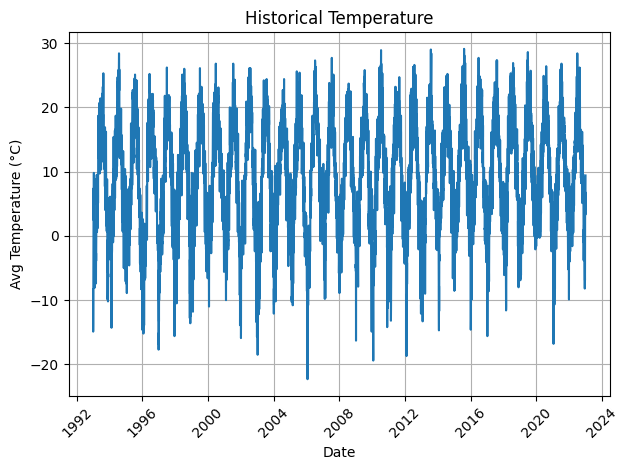

In [ ]:
# Parse date column and clean data
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')

# Handle missing or invalid values in TAVG
df['TAVG'] = pd.to_numeric(df['TAVG'], errors='coerce')  # Convert to float, set invalid to NaN
df['TAVG'] = df['TAVG'].interpolate()  # Fill missing values
df = df[['DATE', 'TAVG']].dropna()

# Plot data
plt.plot(df['DATE'], df['TAVG'])
plt.xlabel('Date')
plt.ylabel('Avg Temperature (°C)')
plt.title('Historical Temperature')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Normalize TAVG
scaler = MinMaxScaler()
scaled_temp = scaler.fit_transform(df['TAVG'].values.reshape(-1, 1))

# Create time series sequences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(scaled_temp, seq_length)
X = X.reshape((X.shape[0], seq_length, 1))


In [ ]:
# Split into training and testing sets (80% train, 20% test)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [ ]:
model = Sequential([
    LSTM(64, input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=8, verbose=1, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0186 - val_loss: 0.0034
Epoch 2/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 3/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 4/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 6/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 8/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0020 - val_loss: 0.0022


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test set
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actuals
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R² Score: {r2:.3f}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Mean Squared Error (MSE): 5.895
Mean Absolute Error (MAE): 1.906
R² Score: 0.916


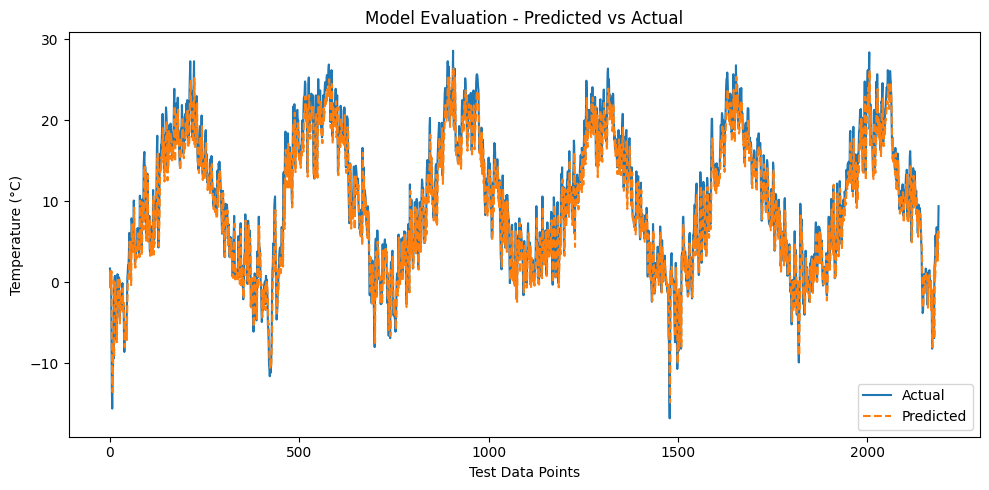

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted", linestyle='dashed')
plt.title("Model Evaluation - Predicted vs Actual")
plt.xlabel("Test Data Points")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
last_seq = scaled_temp[-seq_length:]
predictions = []

for _ in range(7):
    pred = model.predict(last_seq.reshape(1, seq_length, 1), verbose=0)
    predictions.append(pred[0][0])
    last_seq = np.append(last_seq[1:], pred)

preds_actual = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


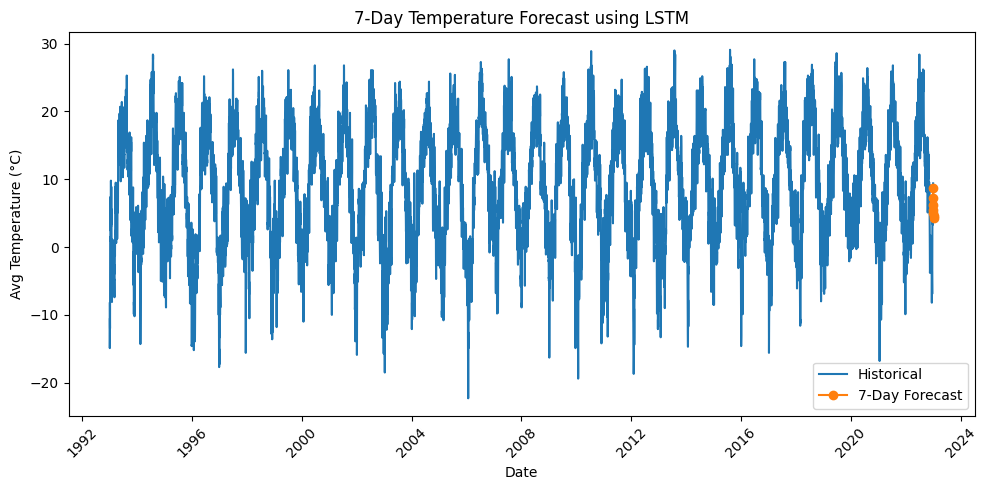

In [ ]:
forecast_dates = pd.date_range(start=df['DATE'].iloc[-1] + pd.Timedelta(days=1), periods=7)

plt.figure(figsize=(10, 5))
plt.plot(df['DATE'], df['TAVG'], label='Historical')
plt.plot(forecast_dates, preds_actual, marker='o', label='7-Day Forecast')
plt.xlabel("Date")
plt.ylabel("Avg Temperature (°C)")
plt.title("7-Day Temperature Forecast using LSTM")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
